## Loading Modules

In [1]:
import os 
import numpy as np
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,add,Dropout

2024-03-14 23:17:01.441309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 23:17:01.441340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 23:17:01.442042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 23:17:01.447038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 23:17:02.048204: W tensorflow/compiler/tf2

In [2]:
import shutil

# Path to the text file containing image names
file_path = r'/home/marocos/thesis/med-image-captioning/data/dataset_20_random_samples.txt'

# Read the file and extract image names
with open(file_path, 'r') as file:
    lines = file.readlines()[1:]  # Exclude the first line


image_names = [line.split(',')[0] for line in lines]

# Define the source and destination folder paths
source_folder_path = r'/home/marocos/mic-images/'
destination_folder_path = r'/home/marocos/thesis/med-image-captioning/images/'

# Ensure the destination folder exists
os.makedirs(destination_folder_path, exist_ok=True)


# Iterate over the list of image names
for image_name in image_names:
    source_image_path = os.path.join(source_folder_path, image_name)
    destination_image_path = os.path.join(destination_folder_path, image_name)
    
    # Check if the image exists in the source folder
    if os.path.exists(source_image_path):
        # Check if the image already exists in the destination folder
        if not os.path.exists(destination_image_path):
            # Copy the image to the destination folder
            shutil.copy2(source_image_path, destination_image_path)
            print(f"Copied {image_name} to destination folder.")
        else:
            print(f"Image {image_name} already exists in destination folder.")
    else:
        print(f"Image {image_name} not found in source folder.")



Image 736c430bcbfd1e49e2065130cc4e3cb5ee91782f_2-Figure5-1.png already exists in destination folder.
Image ad4a099c0e9c0ee984943f2c9243fd5e901d63d0_4-Figure2-1.png already exists in destination folder.
Image ec8b42199b1a1725c0a04bea0489a8c5bbb64e93_2-Figure1-1.png already exists in destination folder.
Image 61f0cc1eef9cd2e27107d6081c337ed93a90bd81_3-Figure7-1.png already exists in destination folder.
Image 06ff9e515f10c2a3873b121b6bc5e9898a016163_2-Figure1-1.png already exists in destination folder.
Image 93f3b379da318b773620631901be72bcee710643_2-Figure1-1.png already exists in destination folder.
Image d36d593ee2a4cd6b94e650eabe60a98c96274ae2_4-Figure9-1.png already exists in destination folder.
Image 27203418d599e2311c234c150d12754e168fb7ac_2-Figure1-1.png already exists in destination folder.
Image 6742672d440339d28cdfd9b88a903a2a51a39c41_1-Figure2-1.png already exists in destination folder.
Image fc7b731fb1f9d54a91fe1c3b85792cef83bb0989_7-Figure6-1.png already exists in destinatio

## Image Feature Extraction

In [3]:
model = VGG16()
# restarcture the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)

In [4]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# extract features from each photo in the directory
features={}
directory=r'/home/marocos/thesis/med-image-captioning/images'

for img_name in tqdm(os.listdir(directory)):
    filename = directory+'/'+img_name

    # load an image from file
    image = load_img(filename,target_size=(224,224))

    # convert the image pixels to a numpy array
    image = img_to_array(image)

    # reshape data for the model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))

    # prepare the image for the VGG model
    image = preprocess_input(image)

    # get features
    feature = model.predict(image,verbose=0)

    # get image id
    image_id = img_name.split('.')[0]

    #save the features
    features[image_id] = feature

In [ ]:
# # save to file
# pickle.dump(features,open(r'D:\med-image-captioning\data\image_features\features.pkl','wb'))

## Loading the captions

In [ ]:
# load the caption features using pickle
with open(r'/home/marocos/thesis/med-image-captioning/data/dataset_20_random_samples.txt','r') as file:
    captions_doc=file.readlines()[1:]

In [ ]:
print(captions_doc)

['736c430bcbfd1e49e2065130cc4e3cb5ee91782f_2-Figure5-1.png,xray examination of the hands of case showing the radial finger defects\n', 'ad4a099c0e9c0ee984943f2c9243fd5e901d63d0_4-Figure2-1.png,epsilon toxin treated gppm showing blistering of nuclear membrane ill defined chromatin and swollen structiireless cytoplasm em\n', 'ec8b42199b1a1725c0a04bea0489a8c5bbb64e93_2-Figure1-1.png,original image from echocardigraphy image after zoom in and translate through program code based on basic echocardiogram images\n', '61f0cc1eef9cd2e27107d6081c337ed93a90bd81_3-Figure7-1.png,ctscan after weeks of osimertinib treatment showed that the lesion had shrunk\n', '06ff9e515f10c2a3873b121b6bc5e9898a016163_2-Figure1-1.png,radiolucent lesion occupying the body of the left mandible axial cone beam computed tomography image\n', '93f3b379da318b773620631901be72bcee710643_2-Figure1-1.png,longitudinal view of left shoulder on ultrasonography and periscapular area shows heterogenous fluid filled cystic mass\n', 

In [ ]:
# Create a mapping of image captions
mapping = {}

for line in tqdm(captions_doc):
    # Split the line by comma
    tokens = line.split(',')

    if len(tokens) >= 2:
        image_id, caption = tokens[0], tokens[1]

        # Remove filename from image_id
        image_id = image_id.split('.')[0]

        # Add to mapping dictionary
        if image_id not in mapping:
            mapping[image_id] = []

        mapping[image_id].append(caption)





100%|██████████| 100/100 [00:00<00:00, 723155.86it/s]


In [ ]:
print(len(mapping))

100


In [ ]:
## add start and end sequence to the captions
for key,captions in mapping.items():
    for i in range(len(captions)):
        captions[i]='<start> '+captions[i]+' <end>'

In [ ]:
all_captions=[]
for key in mapping.keys():
    [all_captions.append(caption) for caption in mapping[key]]

In [ ]:
len(all_captions)

100

In [15]:
print(all_captions[:1])

NameError: name 'all_captions' is not defined

In [ ]:
# tokenize the text

tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [ ]:
print(vocab_size)

562


In [ ]:
max_length=max(len(caption.split()) for caption in all_captions)
print(max_length)

22


## Train test split

In [ ]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.8)
train=image_ids[:split]
test=image_ids[split:]


In [ ]:
# create data generator
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y= list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]

            for caption in captions:
                sequence=tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1,len(sequence)):
                    # split into input and output pair
                    in_seq,out_seq=sequence[:i],sequence[i]

                    # pad input sequence
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]

                    # encode output sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]

                    # store the input and output sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0





## Model Building

In [ ]:
# encoder
# image feature model
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)

# sequence feature layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

# decoder
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

# model definiton
model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')



## Train the model

In [ ]:
epochs = 10
batch_size = 5
steps = len(train)//batch_size

for i in tqdm(range(epochs)):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    
    model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
16/16 [==============================] - 4s 54ms/step - loss: 6.1733
Epoch 2/10
16/16 [==============================] - 1s 57ms/step - loss: 5.3108
Epoch 3/10
16/16 [==============================] - 1s 52ms/step - loss: 4.8456
Epoch 4/10
16/16 [==============================] - 1s 52ms/step - loss: 4.3724
Epoch 5/10
16/16 [==============================] - 1s 54ms/step - loss: 3.8777
Epoch 6/10
16/16 [==============================] - 1s 56ms/step - loss: 3.5352
Epoch 7/10
16/16 [==============================] - 1s 60ms/step - loss: 3.2487
Epoch 8/10
16/16 [==============================] - 1s 54ms/step - loss: 3.1115
Epoch 9/10
16/16 [==============================] - 1s 55ms/step - loss: 2.9992
Epoch 10/10
16/16 [==============================] - 1s 53ms/step - loss: 2.8832


 10%|█         | 1/10 [00:11<01:44, 11.63s/it]

Epoch 1/10
16/16 [==============================] - 1s 55ms/step - loss: 2.7721
Epoch 2/10
16/16 [==============================] - 1s 54ms/step - loss: 2.7394
Epoch 3/10
16/16 [==============================] - 1s 56ms/step - loss: 2.5170
Epoch 4/10
16/16 [==============================] - 1s 55ms/step - loss: 2.4096
Epoch 5/10
16/16 [==============================] - 1s 53ms/step - loss: 2.3793
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 2.3232
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 2.3225
Epoch 8/10
16/16 [==============================] - 1s 55ms/step - loss: 2.3394
Epoch 9/10
16/16 [==============================] - 1s 53ms/step - loss: 2.3659
Epoch 10/10
16/16 [==============================] - 1s 52ms/step - loss: 2.2570


 20%|██        | 2/10 [00:20<01:19,  9.92s/it]

Epoch 1/10
16/16 [==============================] - 1s 52ms/step - loss: 2.0877
Epoch 2/10
16/16 [==============================] - 1s 53ms/step - loss: 1.9451
Epoch 3/10
16/16 [==============================] - 1s 53ms/step - loss: 1.8832
Epoch 4/10
16/16 [==============================] - 1s 53ms/step - loss: 1.8647
Epoch 5/10
16/16 [==============================] - 1s 53ms/step - loss: 1.9261
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 1.9886
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 1.8745
Epoch 8/10
16/16 [==============================] - 1s 53ms/step - loss: 1.6718
Epoch 9/10
16/16 [==============================] - 1s 55ms/step - loss: 1.5503
Epoch 10/10
16/16 [==============================] - 1s 54ms/step - loss: 1.4079


 30%|███       | 3/10 [00:28<01:05,  9.32s/it]

Epoch 1/10
16/16 [==============================] - 1s 53ms/step - loss: 1.3937
Epoch 2/10
16/16 [==============================] - 1s 53ms/step - loss: 1.4004
Epoch 3/10
16/16 [==============================] - 1s 52ms/step - loss: 1.4078
Epoch 4/10
16/16 [==============================] - 1s 52ms/step - loss: 1.3630
Epoch 5/10
16/16 [==============================] - 1s 53ms/step - loss: 1.2898
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 1.1793
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 1.0698
Epoch 8/10
16/16 [==============================] - 1s 53ms/step - loss: 0.9315
Epoch 9/10
16/16 [==============================] - 1s 55ms/step - loss: 0.8369
Epoch 10/10
16/16 [==============================] - 1s 54ms/step - loss: 0.7712


 40%|████      | 4/10 [00:37<00:54,  9.04s/it]

Epoch 1/10
16/16 [==============================] - 1s 54ms/step - loss: 0.7080
Epoch 2/10
16/16 [==============================] - 1s 52ms/step - loss: 0.6748
Epoch 3/10
16/16 [==============================] - 1s 53ms/step - loss: 0.5996
Epoch 4/10
16/16 [==============================] - 1s 53ms/step - loss: 0.6169
Epoch 5/10
16/16 [==============================] - 1s 56ms/step - loss: 0.5691
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 0.5292
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 0.5014
Epoch 8/10
16/16 [==============================] - 1s 53ms/step - loss: 0.3976
Epoch 9/10
16/16 [==============================] - 1s 53ms/step - loss: 0.3655
Epoch 10/10
16/16 [==============================] - 1s 54ms/step - loss: 0.3021


 50%|█████     | 5/10 [00:46<00:44,  8.90s/it]

Epoch 1/10
16/16 [==============================] - 1s 54ms/step - loss: 0.2573
Epoch 2/10
16/16 [==============================] - 1s 53ms/step - loss: 0.2171
Epoch 3/10
16/16 [==============================] - 1s 55ms/step - loss: 0.2019
Epoch 4/10
16/16 [==============================] - 1s 58ms/step - loss: 0.1782
Epoch 5/10
16/16 [==============================] - 1s 53ms/step - loss: 0.1573
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 0.1380
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 0.1193
Epoch 8/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0985
Epoch 9/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0845
Epoch 10/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0752


 60%|██████    | 6/10 [00:54<00:35,  8.84s/it]

Epoch 1/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0699
Epoch 2/10
16/16 [==============================] - 1s 55ms/step - loss: 0.0673
Epoch 3/10
16/16 [==============================] - 1s 55ms/step - loss: 0.0613
Epoch 4/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0560
Epoch 5/10
16/16 [==============================] - 1s 55ms/step - loss: 0.0490
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0446
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0407
Epoch 8/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0396
Epoch 9/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0355
Epoch 10/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0356


 70%|███████   | 7/10 [01:03<00:26,  8.85s/it]

Epoch 1/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0339
Epoch 2/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0287
Epoch 3/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0265
Epoch 4/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0288
Epoch 5/10
16/16 [==============================] - 1s 55ms/step - loss: 0.0297
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0311
Epoch 7/10
16/16 [==============================] - 1s 55ms/step - loss: 0.0242
Epoch 8/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0215
Epoch 9/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0195
Epoch 10/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0193


 80%|████████  | 8/10 [01:12<00:17,  8.82s/it]

Epoch 1/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0180
Epoch 2/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0171
Epoch 3/10
16/16 [==============================] - 1s 55ms/step - loss: 0.0171
Epoch 4/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0150
Epoch 5/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0139
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0134
Epoch 7/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0129
Epoch 8/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0122
Epoch 9/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0115
Epoch 10/10
16/16 [==============================] - 1s 58ms/step - loss: 0.0112


 90%|█████████ | 9/10 [01:21<00:08,  8.79s/it]

Epoch 1/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0109
Epoch 2/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0107
Epoch 3/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0146
Epoch 4/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0176
Epoch 5/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0121
Epoch 6/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0174
Epoch 7/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0227
Epoch 8/10
16/16 [==============================] - 1s 54ms/step - loss: 0.0138
Epoch 9/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0229
Epoch 10/10
16/16 [==============================] - 1s 59ms/step - loss: 0.0458


100%|██████████| 10/10 [01:30<00:00,  9.01s/it]


In [ ]:
# model.save(r'D:\med-image-captioning\model\model_50.h5')

## Generate captions

In [ ]:
def index_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
# generate a description for an image
def predict_caption(model,image,tokenizer,max_length):
    in_text="<start>"

    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],max_length)

        yhat=model.predict([image,sequence],verbose=0)

        # convert probability to integer
        yhat=np.argmax(yhat)

        # convert index to word
        word=index_to_word(yhat,tokenizer)

        if word is None:
            break
        ## append as input for generating the next word
        in_text+=" "+word

        # stop if we cannot generate the next word
        if word=='<end>':
            break
    return in_text

In [ ]:
# evaluate the model

actual,predicted=list(),list()

for key in test:
    try:
        # get actual caption
        captions=mapping[key]

        # generate caption
        y_pred=predict_caption(model,features[key],tokenizer,max_length)

        #split into words
        actual_captions=[caption.split() for caption in captions]
        y_pred=y_pred.split()
        #append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
    except KeyError:
        continue

# calculate BLEU score




In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# calculate BLEU score
print("BLUE-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLUE-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLUE-1: 0.165217
BLUE-2: 0.067126


/home/marocos/thesis/med-image-captioning/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## Visualize the results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def generate_caption(image_name):

    # image_name="780d51420ad492a61d00295adb6919bd492e6bd3_8-Figure3-1.png"
    img_path=r'/home/marocos/thesis/med-image-captioning/images/'+image_name
    img_name=image_name.split('.')[0]
    image=Image.open(img_path)
    captions=mapping[img_name]

    print("----------------Actual Captions----------------")
    print(captions)
    y_pred=predict_caption(model,features[img_name],tokenizer,max_length)
    print("----------------Predicted Caption----------------")
    print(y_pred)
    plt.imshow(image)


----------------Actual Captions----------------
['<start> anterior posterior chest radiograph on day\n <end>']
----------------Predicted Caption----------------
<start> anterior posterior chest radiograph on day end day end end end end end end end end end end end end end end


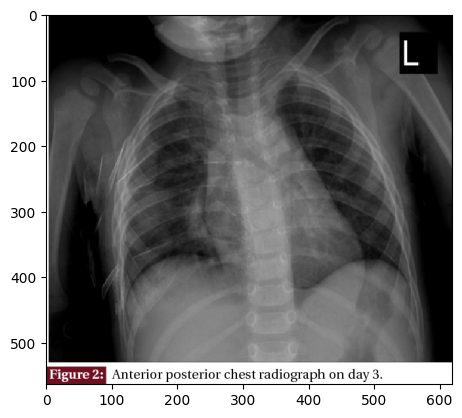

In [ ]:
generate_caption('0aa5071a1b2c3eea63d4622c56469c64be12f1d5_2-Figure2-1.png')